# Notebook to compare SWE DataSources 

# Step 0 Set up Notebook

In [1]:
import pandas as pd
import boto3
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import io
import requests
from io import StringIO
from snowML.datapipe import data_utils as du 
from snowML.LSTM import LSTM_metrics as met
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import numpy as np
import itertools


# Step 1 - Define Functions to Gather Data

In [2]:
def get_UA_data(huc_id): 
    f = f"mean_swe_in_{huc_id}.csv"
    b = "snowml-gold"
    df = du.s3_to_df(f, b)
    df.set_index('day', inplace=True)
    df.index = pd.to_datetime(df.index)
    df["mean_swe"] = df["mean_swe"]/1000
    return df

In [3]:
def get_Skagit(huc_id): 
    f = f"data_prior/wus-sr-skagit-{huc_id}-mean-swe.csv"
    df = pd.read_csv(f)
    df.rename(columns={"time": "day", "mean": "mean_swe"}, inplace=True)
    df.set_index('day', inplace=True)
    df.index = pd.to_datetime(df.index)
    df["huc_id"] = huc_id
    df = df[["mean_swe", "huc_id"]]
    return df
    

In [4]:
def get_UCLA(huc_id): 
    f = f"mean_swe_in_{huc_id}_UCLA.csv"
    b = "snowml-gold"
    df = du.s3_to_df(f, b)
    df.rename(columns={"time": "day", "SWE": "mean_swe"}, inplace=True)
    df.set_index('day', inplace=True)
    df.index = pd.to_datetime(df.index)
    return df

In [5]:
def filter(df, filter_date):
    df_filtered = df[df.index >= filter_date]
    return df_filtered

In [6]:
def gather_data(huc_id, filter_date = "1984-10-01"):
    swe_UA  = filter(get_UA_data(huc_id), filter_date)
    swe_Skagit = filter(get_Skagit(huc_id), filter_date)
    swe_UCLA = filter(get_UCLA(huc_id), filter_date)
    df_dict = {"UA_data":swe_UA, "Skagit_data": swe_Skagit, "UCLA_data":swe_UCLA}
    return df_dict

# Step 2 - Define Plotting And Analysis Functions

In [7]:
def plot_swe(df_dict, huc_id):
    """
    Plots mean_swe vs day for a dictionary of DataFrames with yearly x-axis ticks,
    rotated labels, and no grid lines.

    Parameters:
    df_dict (dict): Dictionary where keys are labels and values are DataFrames 
                    with 'mean_swe' column and 'day' as index.
    """
    plt.figure(figsize=(12, 6))
    
    for label, df in df_dict.items():
        plt.plot(df.index, df['mean_swe'], label=label)
    
    plt.xlabel('Year')
    plt.ylabel('Mean SWE')
    plt.title(f'Mean SWE over Time for Huc {huc_id}')
    plt.legend()

    # Format x-axis to show ticks yearly and rotate them
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()




In [8]:
def plot_compare(df_dict, huc_id):
    plot_swe(df_dict, huc_id)

In [17]:


def similarity(df_dict):
    """
    Computes R-squared, Pearson correlation, alpha, and beta between 'mean_swe' columns 
    for each pair of DataFrames in df_dict.

    Parameters:
    df_dict (dict): Dictionary where keys are identifiers and values are DataFrames
                    with a 'mean_swe' column.
    """
    keys = list(df_dict.keys())
    results = []

    for key1, key2 in itertools.combinations(keys, 2):
        df1 = df_dict[key1]
        df2 = df_dict[key2]

        # Align on index (e.g., day)
        df1_aligned, df2_aligned = df1.align(df2, join='inner')

        a = df1_aligned['mean_swe']
        b = df2_aligned['mean_swe']

        r2 = r2_score(a, b)
        pearson_corr, _ = pearsonr(a, b)
        alpha = np.std(a) / np.std(b) if np.std(b) != 0 else np.nan
        beta = np.mean(a) / np.mean(b) if np.mean(b) != 0 else np.nan

        results.append((key1, key2, pearson_corr, alpha, beta, r2))

    # Create and print a clean DataFrame of results
    results_df = pd.DataFrame(
        results, 
        columns=['Dataset 1', 'Dataset 2', 'Pearson Corr', 'Ratio_var', 'Ratio_means', 'R-squared']
    )
    print(results_df.round(3))




# Step 3 - PLot and Analyze Data 

In [10]:
hucs = [1711000504, 1711000505, 1711000506, 1711000507, 1711000508, 1711000509, 1711000511] 

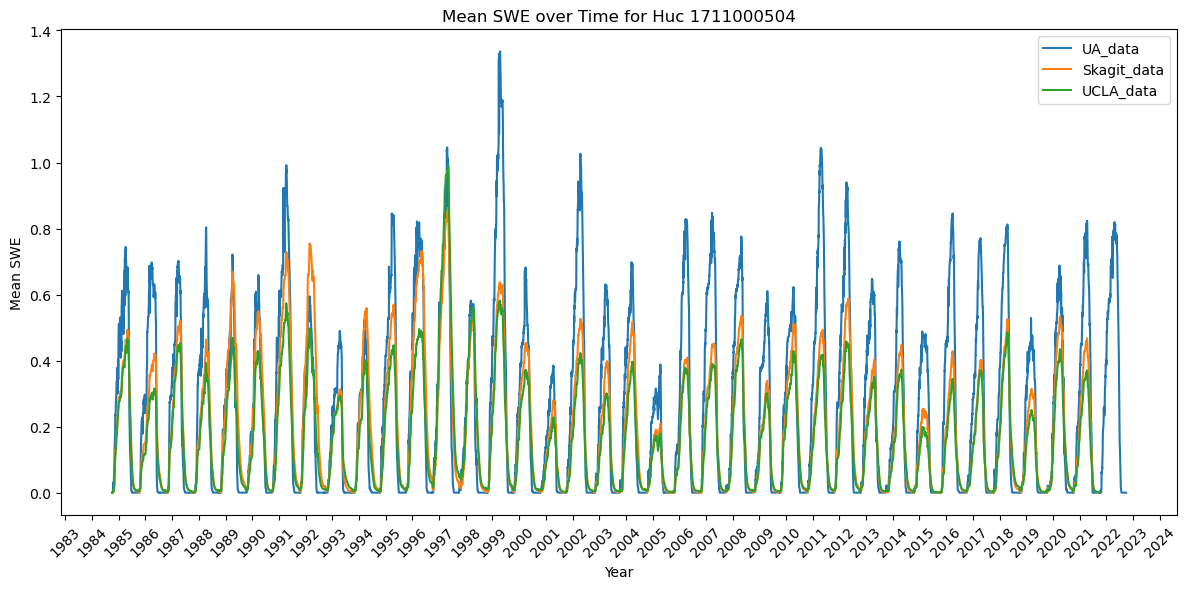

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.905      1.442        1.308      0.727
1      UA_data    UCLA_data         0.901      1.697        1.559      0.606
2  Skagit_data    UCLA_data         0.969      1.176        1.192      0.898


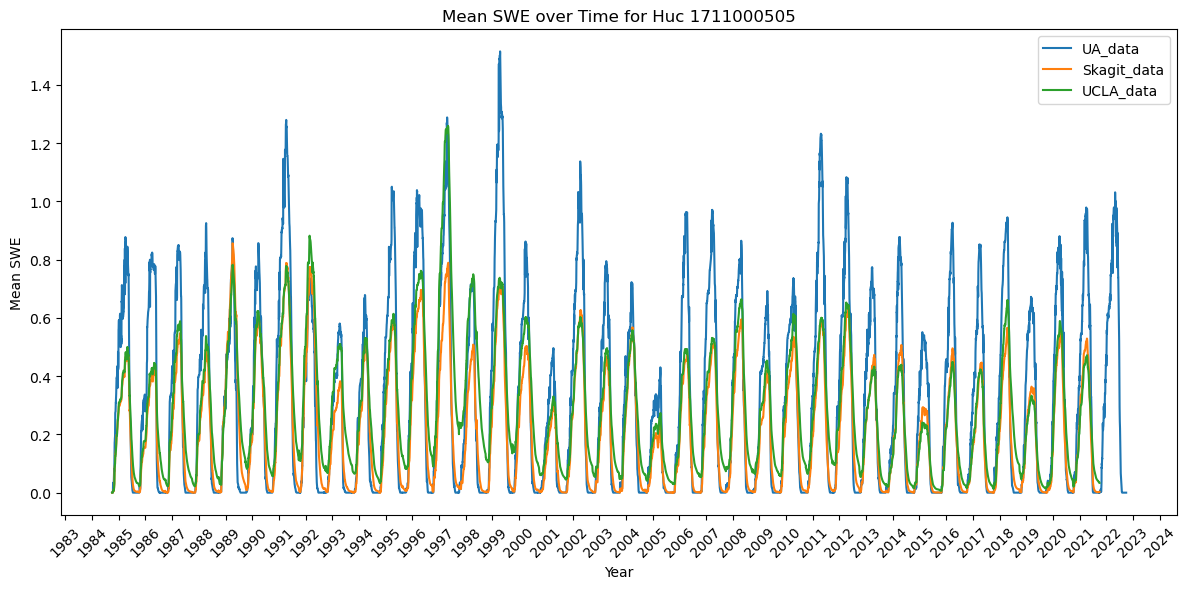

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.944      1.593        1.467      0.698
1      UA_data    UCLA_data         0.862      1.537        1.123      0.688
2  Skagit_data    UCLA_data         0.940      0.965        0.766      0.774


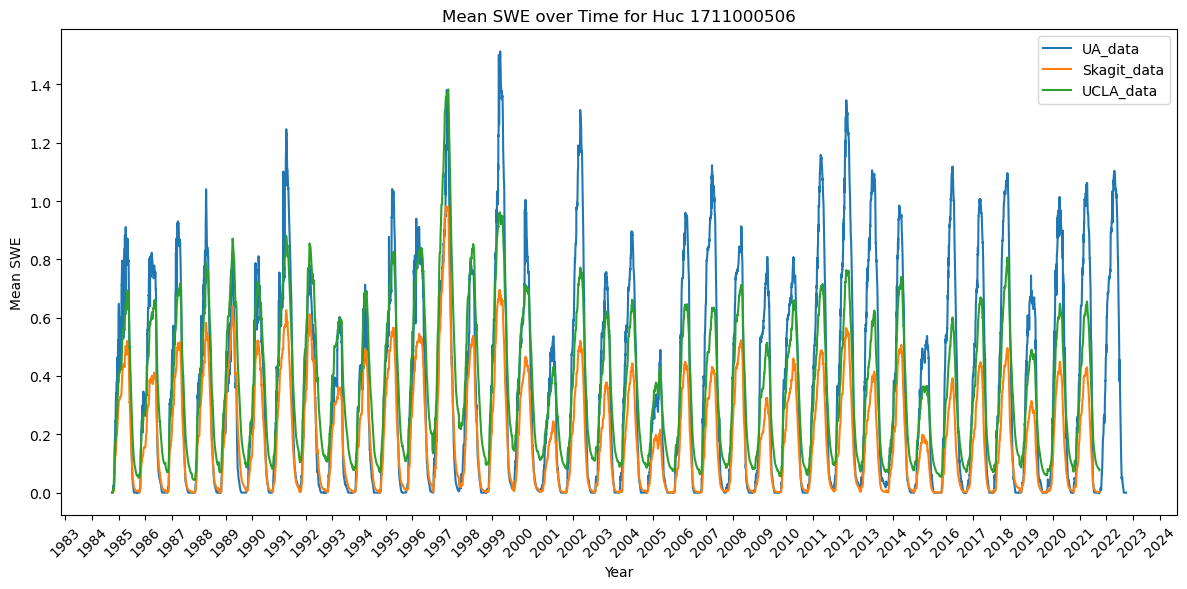

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.918      1.861        1.839      0.483
1      UA_data    UCLA_data         0.896      1.452        0.998      0.759
2  Skagit_data    UCLA_data         0.984      0.780        0.543      0.128


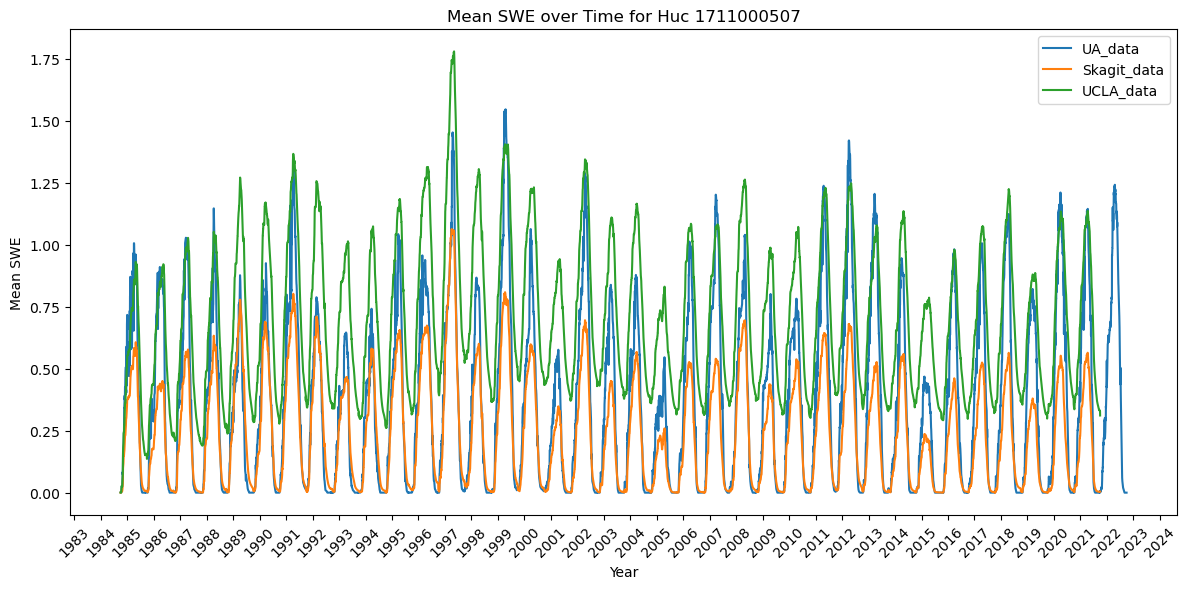

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.936      1.585        1.513      0.664
1      UA_data    UCLA_data         0.888      1.169        0.518     -0.103
2  Skagit_data    UCLA_data         0.950      0.737        0.342     -3.434


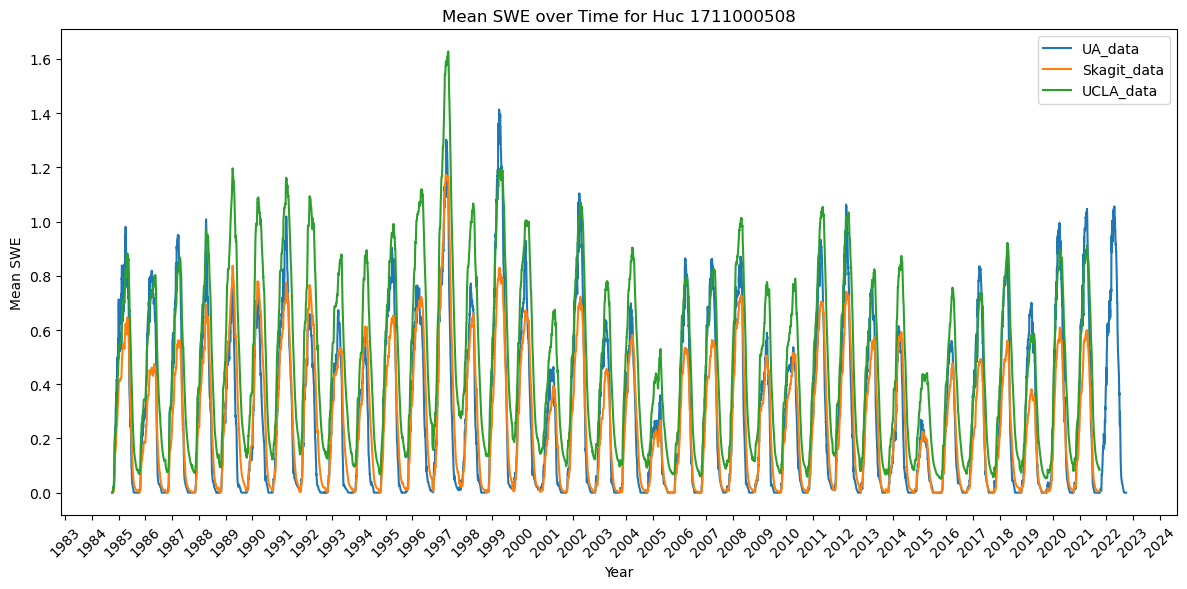

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.922      1.259        1.110      0.825
1      UA_data    UCLA_data         0.878      0.956        0.609      0.375
2  Skagit_data    UCLA_data         0.985      0.760        0.548      0.084


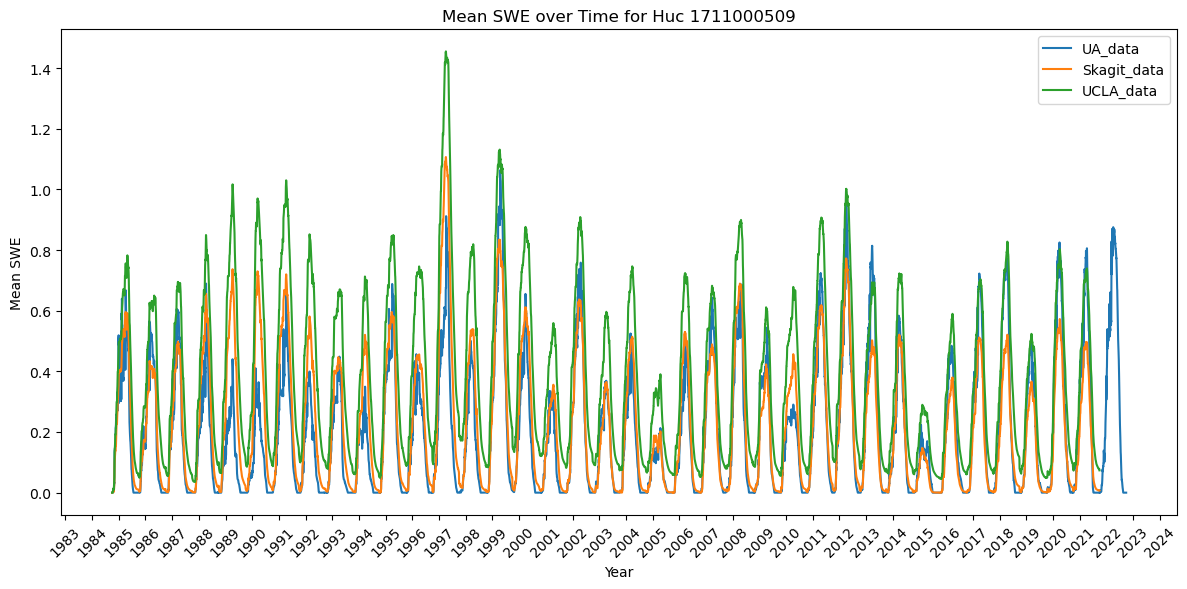

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.897      0.989        0.899      0.782
1      UA_data    UCLA_data         0.878      0.776        0.525     -0.112
2  Skagit_data    UCLA_data         0.989      0.784        0.584      0.360


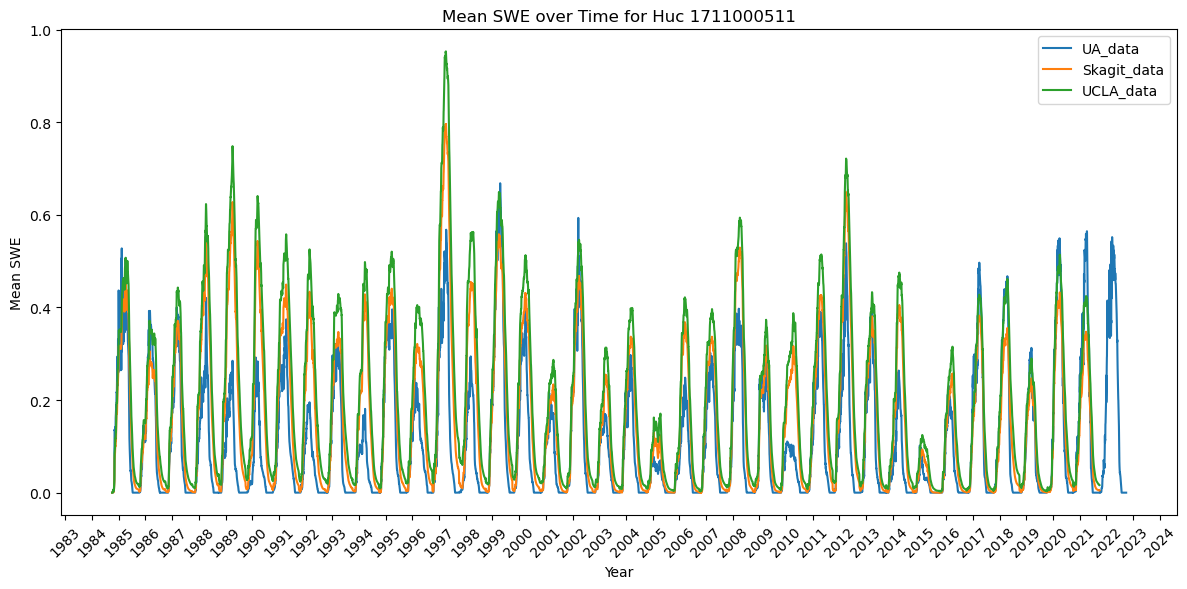

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.857      0.840        0.677      0.476
1      UA_data    UCLA_data         0.837      0.728        0.530     -0.101
2  Skagit_data    UCLA_data         0.996      0.866        0.783      0.890


In [18]:
for huc_id in hucs: 
    df_dict = gather_data(huc_id)
    plot_compare(df_dict, huc_id)
    df_dict = gather_data(huc_id)
    similarity(df_dict)

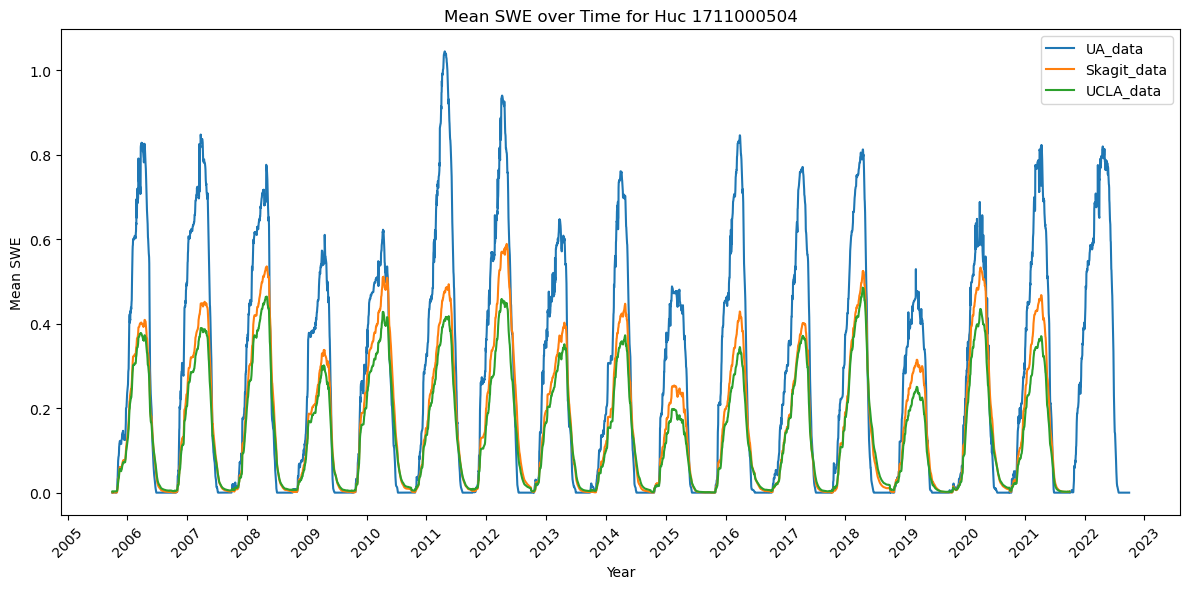

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.951      1.681        1.543      0.668
1      UA_data    UCLA_data         0.953      2.005        1.803      0.527
2  Skagit_data    UCLA_data         0.995      1.193        1.168      0.943


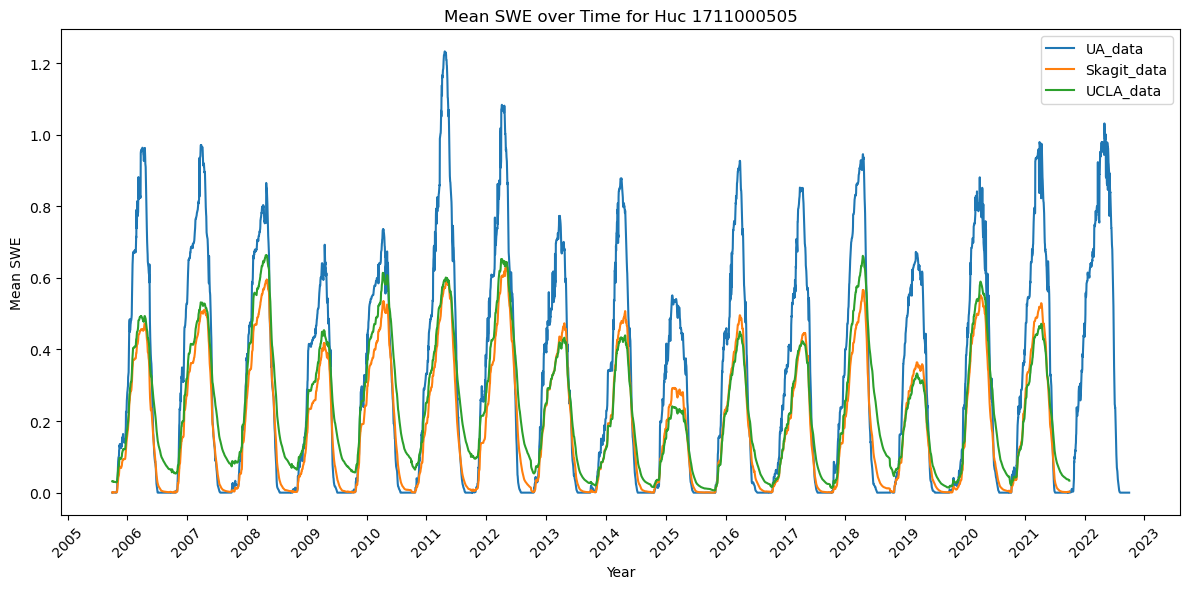

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.971      1.718        1.593      0.661
1      UA_data    UCLA_data         0.911      1.778        1.302      0.657
2  Skagit_data    UCLA_data         0.966      1.035        0.818      0.879


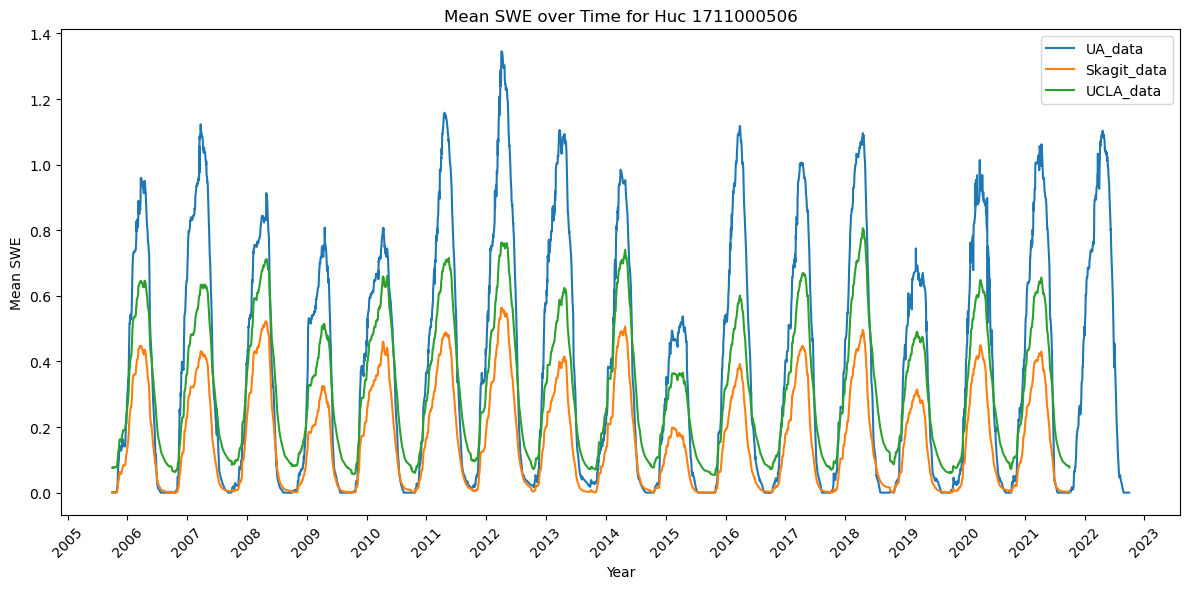

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.970      2.293        2.297      0.311
1      UA_data    UCLA_data         0.965      1.787        1.224      0.731
2  Skagit_data    UCLA_data         0.986      0.779        0.533      0.057


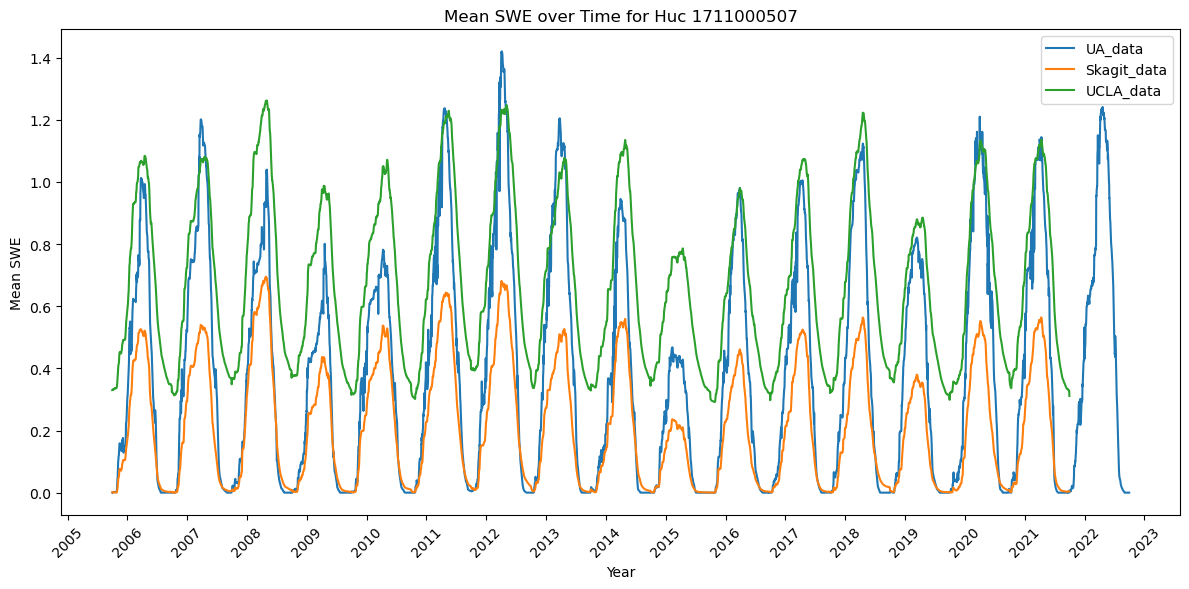

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.966      1.863        1.786      0.548
1      UA_data    UCLA_data         0.941      1.374        0.559      0.197
2  Skagit_data    UCLA_data         0.975      0.737        0.313     -4.614


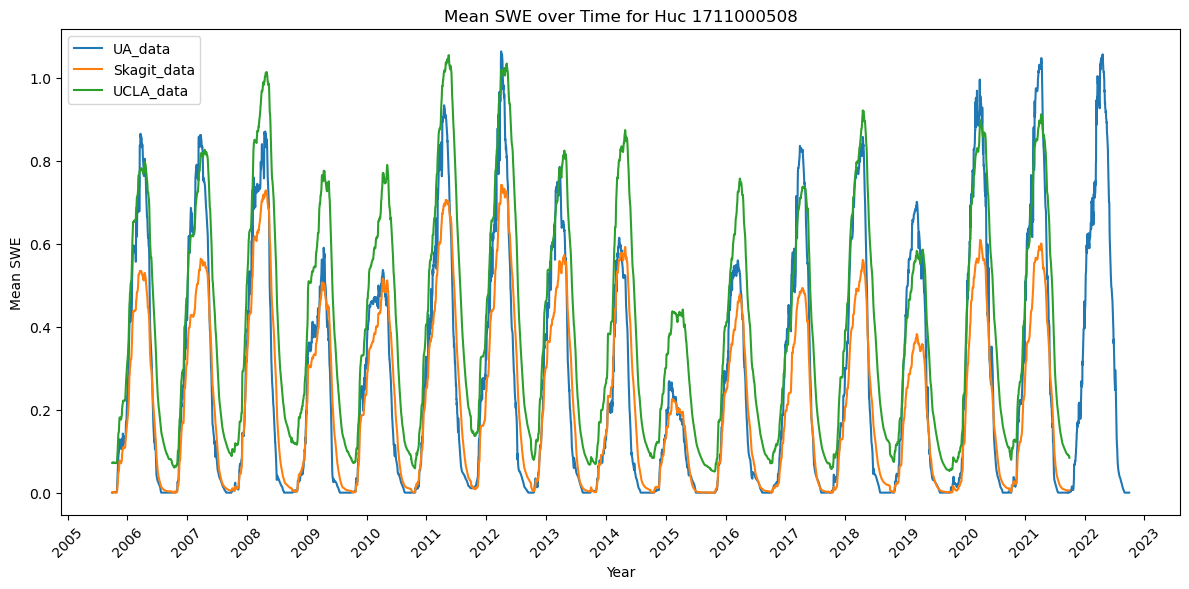

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.941      1.366        1.197      0.818
1      UA_data    UCLA_data         0.906      1.034        0.659      0.588
2  Skagit_data    UCLA_data         0.988      0.757        0.551      0.120


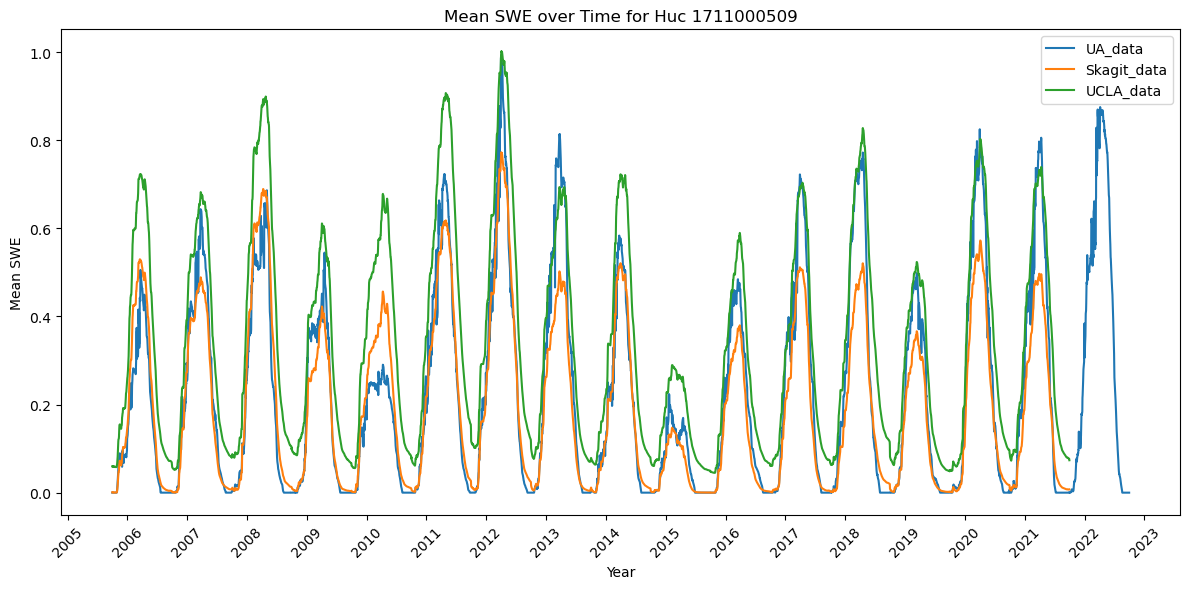

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.950      1.196        1.124      0.878
1      UA_data    UCLA_data         0.943      0.937        0.651      0.614
2  Skagit_data    UCLA_data         0.991      0.784        0.580      0.358


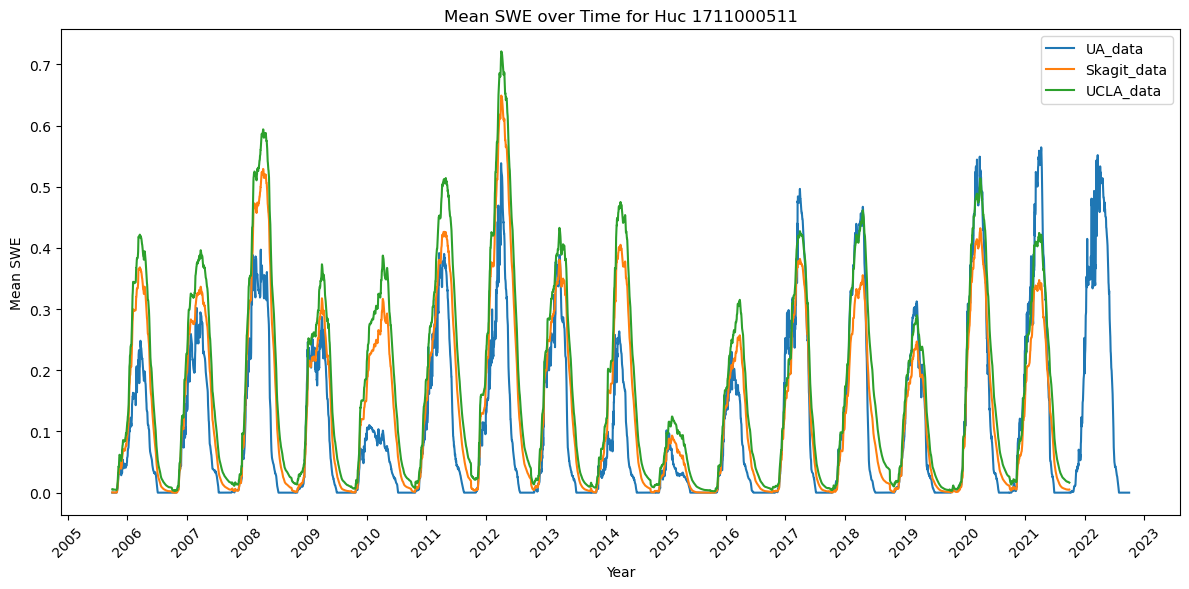

     Dataset 1    Dataset 2  Pearson Corr  Ratio_var  Ratio_means  R-squared
0      UA_data  Skagit_data         0.873      0.932        0.757      0.656
1      UA_data    UCLA_data         0.866      0.819        0.603      0.353
2  Skagit_data    UCLA_data         0.997      0.878        0.798      0.913


In [19]:
filter_date = "2005-10-01"
for huc_id in hucs: 
    df_dict = gather_data(huc_id, filter_date = filter_date)
    plot_compare(df_dict, huc_id)
    similarity(df_dict)
    